# Time Series Analysis

## Box-Jenkins ARMA models

### Explain AR(1) and MA(1) by cobweb theory
* AR(1): assume producer predicts future price based on past price
* MA(1): error correction
* Structured form and Reduced form

In [1]:
class Market:

    def __init__(self, ad, bd, az, bz):
        """
        Set up market parameters.  All parameters are scalars.      
        """
        self.ad, self.bd, self.az, self.bz = ad, bd, az, bz
        if ad < az:
            raise ValueError('Insufficient demand.')

    def price(self):
        "Compute equilibrium price"
        return  (self.ad - self.az) / (self.bd + self.bz)

    def quantity(self):
        "Compute equilibrium quantity"
        return  self.ad - self.bd * self.price()

    def inverse_demand(self, x):
        "Compute inverse demand"
        return self.ad / self.bd - (1 / self.bd)* x

    def inverse_supply(self, x):
       "Compute inverse supply curve without tax"
       return -(self.az / self.bz) + (1 / self.bz) * x

### Stationarity and stability
* Weak stationary definition:
    * Expectation, Variation, Corvariance are finite constant
    * Also known as covariance stationary, 2nd-order stationary

* White noise
	* A time series random variable with Expectation = 0, Variation = const, Autocovariance = 0
		* E(Epst) = 0 for all t
		* var(Epst) = const for all t
		* cov(Epst, Epst-k) = cov(Epst-j, Epst-j-k) = 0 for all j, k and j != k

### ARMA(p, q): stationary time series model
* (1 - 0.5L - 0.2L^2 - 0.1L^3) Yt = (1 + 0.5L + 0.3L^2) Epst

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels as sm

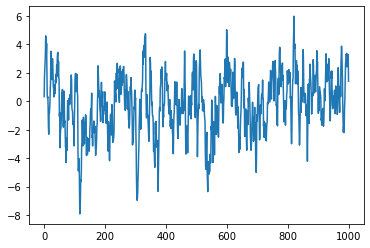

In [10]:
from statsmodels.tsa.arima_process import ArmaProcess
arparams = np.array([0.5, 0.2, 0.1])
maparams = np.array([0.5, 0.3])
ARMA = ArmaProcess(np.r_[1, -arparams], np.r_[1, maparams])
y = ARMA.generate_sample(1000)
plt.plot(y)
plt.show()

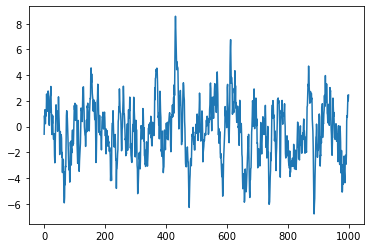

In [5]:
from statsmodels.tsa.arima_process import arma_generate_sample
y = arma_generate_sample([1, -0.5, -0.2, -0.1], [1, 0.5, 0.3], 1000)
plt.plot(y)
plt.show()

### Determine lags by ACF/PACF
* MA(q) model has a ACF plot truncated after lag q
* AR(p) model has a PACF plot truncated after lag p

In [5]:
# from raw data
from statsmodels.tsa.stattools import acf, pacf
acf_coef = acf(y, nlags=12, qstat=True)
pacf_coef = pacf(y, nlags=12, alpha=0.05)

//anaconda3/lib/python3.7/site-packages/statsmodels/tsa/stattools.py:572: FutureWarning: fft=True will become the default in a future version of statsmodels. To suppress this warning, explicitly set fft=False.
  FutureWarning


In [6]:
# by theoretical ARMA parameters
from statsmodels.tsa.arima_process import arma_acf, arma_pacf
acf_coef = arma_acf(np.r_[1, -arparams], np.r_[1, maparams], lags=12)
pacf_coef = arma_pacf(np.r_[1, -arparams], np.r_[1, maparams], lags=12)

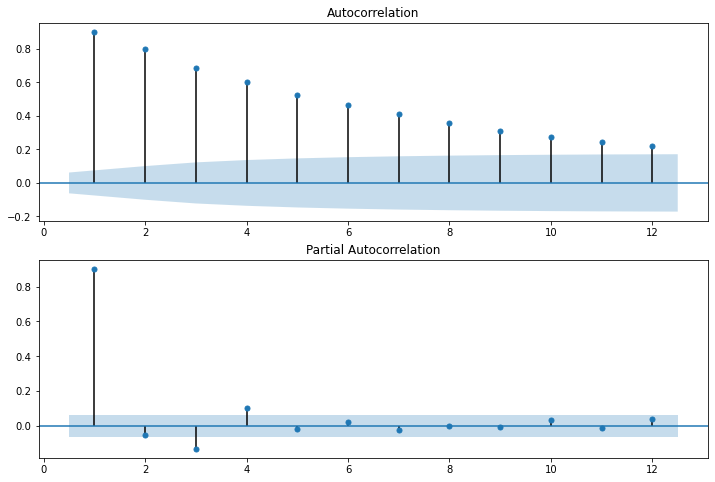

In [7]:
# make plots
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = plot_acf(y, lags=12, zero=False, ax=ax1)
ax2 = fig.add_subplot(212)
fig = plot_pacf(y, lags=12, zero=False, ax=ax2)

### The invertibility of MA and duality of AR and MA

In [8]:
from statsmodels.tsa.arima_process import ar2arma, arma2ar, arma2ma

## ARMA Estimation

PROCEDURE:
1. Determine p lags and q lags by ACF and PACF
2. Estimate p and q by OLS and check significance
3. Check residual autocorrelation by Q statistics or LM statistics
4. Check residual normality by JB statistics
5. Select model by AIC, SBC and etc. 

### Estimation

In [12]:
from statsmodels.tsa.arima_model import ARMA
model = ARMA(y, order=(3, 2)).fit(trend='nc', disp=False)
print("Model parameters: %s" % model.params)
print()
print(model.summary())

Model parameters: [0.46940016 0.08160513 0.19018239 0.50674234 0.41017432]

                              ARMA Model Results                              
Dep. Variable:                      y   No. Observations:                 1000
Model:                     ARMA(3, 2)   Log Likelihood               -1398.026
Method:                       css-mle   S.D. of innovations              0.979
Date:                Sun, 05 Jul 2020   AIC                           2808.051
Time:                        01:52:11   BIC                           2837.498
Sample:                             0   HQIC                          2819.243
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1.y        0.4694      0.164      2.869      0.004       0.149       0.790
ar.L2.y        0.0816      0.191      0.426      0.670 

### Q statistics: Box-Pierce Q statistics / Ljung-Box Q statistics

In [10]:
# LB Q statistics as a modified BP Q statistics for small sample size
residual = model.resid
acf(residual, nlags=12, qstat=True)

from statsmodels.stats.diagnostic import acorr_ljungbox, acorr_lm
# acorr_lm(residual)
acorr_ljungbox(residual, lags=12, boxpierce=True, return_df=True)

//anaconda3/lib/python3.7/site-packages/statsmodels/tsa/stattools.py:572: FutureWarning: fft=True will become the default in a future version of statsmodels. To suppress this warning, explicitly set fft=False.
  FutureWarning


,lb_stat,lb_pvalue,bp_stat,bp_pvalue
1,0.000016,0.996775,0.000016,0.996780
2,0.000846,0.999577,0.000842,0.999579
3,0.113458,0.990175,0.112892,0.990247
4,0.469702,0.976383,0.467004,0.976633
5,0.496549,0.992249,0.493663,0.992353
6,0.588885,0.996583,0.585262,0.996641
7,1.080309,0.993427,1.072272,0.993577
8,1.098463,0.997546,1.090245,0.997611
9,1.865902,0.993415,1.849259,0.993633
10,2.042167,0.996007,2.023413,0.996158


### JB statistics: Jarque-Bera test

In [20]:
from statsmodels.stats.stattools import jarque_bera, omni_normtest
print(pd.Series(jarque_bera(residual), index=['JB', 'JBpv', 'skew', 'kurtosis']))
print()
print(omni_normtest(residual))

JB          1.105142
JBpv        0.575468
skew       -0.059812
kurtosis    2.889485
dtype: float64

NormaltestResult(statistic=1.0238969660624495, pvalue=0.5993266625432065)


### Model selection
1. If Q statistics is significantly not zero at small lags, consider to add AR terms
2. If Q statistics is significantly not zero after large lags or continuous lags, consider to add MA terms
3. Increase p and q in ARMA(p, q) model is estimate by OLS until residual become white noise
4. If multiple models pass residual test, pick one model by model selection criteiron

* Goodness of fit: Evaluate model by **in-sample** data
    * R2 (coefficient of determination) / Adj-R2 (Adjusted coefficient of determination)
    * AIC (Akaike Information Criterion) / SBIC (Schwartz Bayesian Information Criterion) / HQC (Hannan-Quinn Criterion)
        * All in all, the lower the better
        * Reference criterion:
            1. sample size <= 100: AIC
            2. 100 < sample size <= 600: HQC
            3. sample size > 600: BIC
        * Empirical rules
            1. SBIC prefers model with less parameters)  
            2. SBIC performs better with large sample size  
            3. Compare with AIC, SBIC results are more inconsistent under different sample size
    * LR test (Likelihood Ratio test)
        * Compare Unrestricted model and Restricted model with hypothesis test
            * LR = -2(LR-LU) ~ Chi(m)
            * LR, LU: log likelihood of model
            * m: restricted number

* Forecastability: Evaluate model by **out-of-sample** data
    * n-period-ahead forecast
        * Iterative forecast (dynamic forecast)
            * Forecast by n-period-ahead *predicted value*
        * Recursive updating forecast (static forecast)
            * Forecast by n-period-ahead *real value*
    * RMSE (Root Mean Square Error) / MAE (Mean Absolute Error) / RAPE (Root Absolute Percentage Error)

## Structural Change
* If changing point is known
    * Chow test: Using the concept of F test in joint hypothesis test restricted/unretricted model (adding dummy variabls)
        * breakpoint test
        * predictive test
* If changing point is unknown
    * Quandt-Andrews breakpoint test: "Moving" Chow test
    * CUSUM test
* Threshold Autoregressive model (TAR)

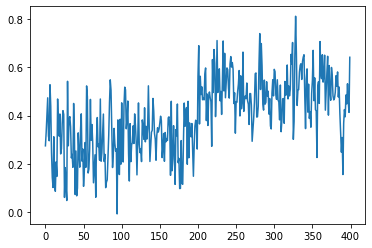

In [114]:
y1 = arma_generate_sample([1, -0.2], [1], scale=0.1, nsample=200) + 0.3
y2 = arma_generate_sample([1, -0.2], [1], scale=0.1, nsample=200) + 0.5
y = np.r_[y1, y2]
plt.plot(y)
plt.show()